im2latex
=============

Data Curation
------------

This notebook uses the [im2latex-100k dataset from Harvard NLP](https://zenodo.org/record/56198#.WT4fsxMrJE4) from a [Harvard NLP project](http://lstm.seas.harvard.edu/latex/) generated using [their code]( https://github.com/Miffyli/im2latex-dataset). This notebook loads png files generated using [textogif](https://www.fourmilab.ch/webtools/textogif/textogif.html) (via the abovementioned sourcecode), curates the data, converts it to numpy arrays and finally stores it as pickle files. 

This source code is adapted from a [Udacity Deep Learning](https://www.udacity.com/course/deep-learning--ud730) course [assignment](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/udacity/1_notmnist.ipynb).

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image as ipImage
from PIL import Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
from mpl_toolkits.axes_grid1 import ImageGrid

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

---
Check 1
---------

Let's take a peek at some of the data to make sure it looks sensible.

---

## PNG Format Channels
The PNG files in our data have a varying number of channels (4 and 1). Here's a table from [Wikipedia](https://en.wikipedia.org/wiki/Portable_Network_Graphics) explaining the channels.

<table class="wikitable floatright">
<caption>PNG color options<sup id="cite_ref-15" class="reference"><a href="#cite_note-15">[15]</a></sup></caption>
<tbody><tr>
<th colspan="7">Bits per pixel</th>
</tr>
<tr>
<th rowspan="2">Color option</th>
<th rowspan="2">Channels</th>
<th colspan="5">Bits per channel</th>
</tr>
<tr>
<th>1</th>
<th>2</th>
<th>4</th>
<th>8</th>
<th>16</th>
</tr>
<tr>
<th>Indexed</th>
<th>1</th>
<td style="background:#9F9;vertical-align:middle;text-align:center;" class="table-yes">1</td>
<td style="background:#9F9;vertical-align:middle;text-align:center;" class="table-yes">2</td>
<td style="background:#9F9;vertical-align:middle;text-align:center;" class="table-yes">4</td>
<td style="background:#9F9;vertical-align:middle;text-align:center;" class="table-yes">8</td>
<td style="background:#F99;vertical-align:middle;text-align:center;" class="table-no"></td>
</tr>
<tr>
<th>Grayscale</th>
<th>1</th>
<td style="background:#9F9;vertical-align:middle;text-align:center;" class="table-yes">1</td>
<td style="background:#9F9;vertical-align:middle;text-align:center;" class="table-yes">2</td>
<td style="background:#9F9;vertical-align:middle;text-align:center;" class="table-yes">4</td>
<td style="background:#9F9;vertical-align:middle;text-align:center;" class="table-yes">8</td>
<td style="background:#9F9;vertical-align:middle;text-align:center;" class="table-yes">16</td>
</tr>
<tr>
<th>Grayscale and alpha</th>
<th>2</th>
<td style="background:#F99;vertical-align:middle;text-align:center;" class="table-no"></td>
<td style="background:#F99;vertical-align:middle;text-align:center;" class="table-no"></td>
<td style="background:#F99;vertical-align:middle;text-align:center;" class="table-no"></td>
<td style="background:#9F9;vertical-align:middle;text-align:center;" class="table-yes">16</td>
<td style="background:#9F9;vertical-align:middle;text-align:center;" class="table-yes">32</td>
</tr>
<tr>
<th>Truecolor</th>
<th>3</th>
<td style="background:#F99;vertical-align:middle;text-align:center;" class="table-no"></td>
<td style="background:#F99;vertical-align:middle;text-align:center;" class="table-no"></td>
<td style="background:#F99;vertical-align:middle;text-align:center;" class="table-no"></td>
<td style="background:#9F9;vertical-align:middle;text-align:center;" class="table-yes">24</td>
<td style="background:#9F9;vertical-align:middle;text-align:center;" class="table-yes">48</td>
</tr>
<tr>
<th>Truecolor and alpha</th>
<th>4</th>
<td style="background:#F99;vertical-align:middle;text-align:center;" class="table-no"></td>
<td style="background:#F99;vertical-align:middle;text-align:center;" class="table-no"></td>
<td style="background:#F99;vertical-align:middle;text-align:center;" class="table-no"></td>
<td style="background:#9F9;vertical-align:middle;text-align:center;" class="table-yes">32</td>
<td style="background:#9F9;vertical-align:middle;text-align:center;" class="table-yes">64</td>
</tr>
</tbody></table>

We'll load files using the flatten=True flag so that the RGB channels get flattened into a single grayscale value.

In [48]:
def displayRandImage(root):
    path = os.path.join(root, np.random.choice(filter(lambda f: f.endswith('.png'),os.listdir(root))));
    image_data = ndimage.imread(path).astype(float)
    print(path, ' ', image_data.shape)
    display(ipImage(filename=path, format='png', unconfined=True))
    return path, image_data.shape[1]


./generated/formula_images/7ab73f8c10747e0_basic.png   (68, 362, 4)


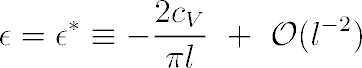

./generated/formula_images/859539fdf619f02_basic.png   (73, 686)


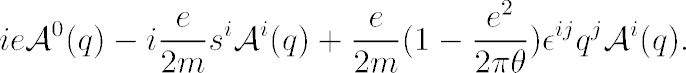

./generated/formula_images/7239bac5f418787_basic.png   (70, 350)


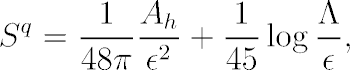

In [49]:
image_folder = './generated/formula_images/'
paths = [displayRandImage(image_folder) for _ in range(3)]

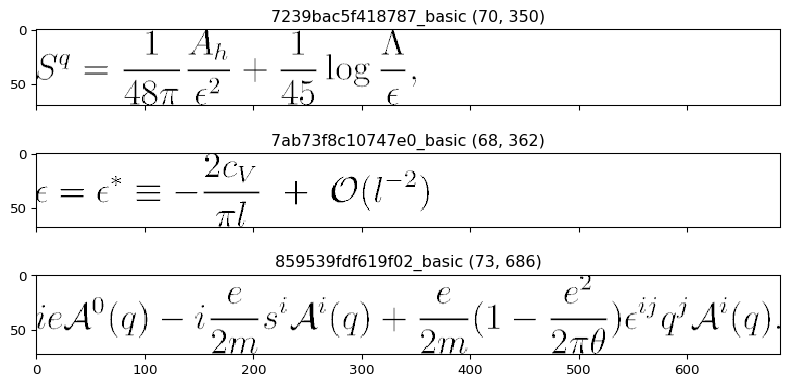

In [55]:
## Display a few images just for checking
try:
    plt.close(fig)
except:
    pass

my_dpi = 96
fig = plt.figure(num=1, figsize=(10,10), dpi=my_dpi)
grid = ImageGrid(fig, 111, nrows_ncols=(3,1), axes_pad=(0.1, 0.5),  aspect=True)
 
def plotImage(path,pos):
    image_data = ndimage.imread(path, flatten=True)
    title = os.path.splitext(os.path.basename(path))[0] + ' %s'%(image_data.shape,)
    grid[pos].set_title( title )
    grid[pos].imshow(image_data, cmap="gray")
#     plt.imshow(image_data, cmap="gray"

# sort images in ascending order of their width otherwise ImageGrid will truncate the
# wider image.
paths = sorted(paths, key= lambda x: x[1])

for i in range(len(paths)):
    plotImage(paths[i][0], i)



In [68]:
images = filter(lambda s: s.endswith('.png'), os.listdir(image_folder))
sizes = []
for image in images:
    try:
        im = Image.open(os.path.join(image_folder,image))
        sizes.append(im.size)
    except Exception as e:
        #print(e)
        pass
    
print (len(sizes))
len(images)

102176


102458

In [81]:
widths = [size[0] for size in sizes]
heights = [size[1] for size in sizes]
def printStats(var):
    print (np.mean(var), np.median(var), np.std(var))

In [82]:
printStats(heights)
printStats(widths)

66.706995772 70.0 33.7684827248
542.384464062 500.0 248.877499208


Data Whitening
--------------

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [ ]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

---
Check 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray.

---

In [ ]:
fig = plt.figure("Problem2", (10.9, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(2,10), axes_pad=(0.1, 0.5))

def displayOneImageFromPickle(ppath, pos, label):
    global grid
    try:
      with open(ppath, 'rb') as f:
        arrs = pickle.load(f)
        num_images = arrs.shape[0];
        img_idx = np.random.randint(0, high=num_images)
        arr = arrs[img_idx]
        print(ppath, " num_images = ", num_images)
        print(ppath,"[", img_idx, "] shape = ", np.shape(arr), " dtype = ", arr.dtype, ", mean,min,max = ", np.mean(arr), np.min(arr), np.max(arr))
        fig.add_axes
        grid[pos].set_title(label)
        grid[pos].imshow(arr, cmap="gray")
    except Exception as e:
      print('Unable to process data from', ppath, ':', e)
      raise


def verifyImageData(msg, pickle_filepaths, start_pos=0):
    print(msg, pickle_filepaths)
    end_pos = start_pos + len(pickle_filepaths)
    labels = map(lambda path: os.path.splitext(os.path.basename(path))[0], pickle_filepaths)
    print (labels)
    map(displayOneImageFromPickle, pickle_filepaths, range(start_pos, end_pos), labels)
    return end_pos

def verifyImages():
    pos = verifyImageData("Training Data Folders: ", train_datasets)
    verifyImageData("Test Data Folders: ", test_datasets, pos)

verifyImages()
#plt.close("all")

Training, Validation and Test Datasets
--------------------------------------

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [ ]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [ ]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  print("randomize done")
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

print("Randomization is done")

---
Check Again
---------
Convince yourself that the data is still good after shuffling!

---

In [ ]:
label_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J')

def displayRandImagesFromArray(desc, arrs, labels, sample_size=10):
    num_images = arrs.shape[0]
    print(desc, " num_images = ", num_images)
    fig = plt.figure(figsize=(10.9, 5))
    grid = ImageGrid(fig, 111, nrows_ncols=(1,10), axes_pad=(0.1, 0.5))

    for i in range(sample_size):
        img_idx = np.random.randint(low=0, high=num_images)
        arr = arrs[img_idx]
        print(desc,"[", img_idx, "] shape = ", np.shape(arr), " dtype = ", arr.dtype,
              ", mean,min,max = ", np.mean(arr), np.min(arr), np.max(arr))
        grid[i].set_title(label_names[labels[img_idx]])
        grid[i].imshow(arr, cmap="gray")

def displayRandImages():
    displayRandImagesFromArray("Training Dataset: ", train_dataset, train_labels)
    displayRandImagesFromArray("Test Dataset: ", test_dataset, test_labels)
    displayRandImagesFromArray("Validation Dataset: ", valid_dataset, valid_labels)

displayRandImages()
#plt.close("all")
print("Done with data verification")

Finally, let's save the data for later reuse:

In [ ]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise


In [ ]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)
del train_dataset, train_labels, valid_dataset, valid_labels, test_dataset, test_labels

---
Check for Duplicates
--------------------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

---

In [ ]:
#Create unique validation and test sets

def getFileList(root):
    dirs = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J')
    filelist = np.array([ os.path.join(dirpath, filename) for d in dirs for dirpath, dirnames, filenames in os.walk(root + '/' + d) for filename in filenames])
    print("Files under %s = "% root, filelist.shape)
    n1 = filelist.size
    filelist2 = np.unique(filelist)
    n2 = filelist2.size
    print("% Duplicates = ", ((n1-n2)*100.0)/n1)
    return filelist

train_files = getFileList('./notMNIST_large')
test_files = getFileList('./notMNIST_small')

del train_files
del test_files




Check for Similar Images
------------------------

- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent models.

In [ ]:
def loadFlattenedData(pickle_file):
    try:
      with open(pickle_file, 'rb') as f:
        data = pickle.load(f)
        print ("loaded data ", data.viewkeys())
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
    x = data["train_dataset"]
    v = data["valid_dataset"]
    t = data["test_dataset"]
    
    A = [a.reshape(a.shape[0],-1) for a in (x,v,t)]
    
    return A[0], A[1], A[2]

x, v, t = loadFlattenedData('notMNIST.pickle')
print("Test, Validate & Train Data Shapes = ", x.shape, v.shape, t.shape)



In [ ]:
from pandas import DataFrame

def calcDupes(m, desc):
    # calculate normalized covariance matrix
    m = np.mat(np.corrcoef(m))
    n = m.shape[0]
    similar = 0.95

    # zero out the matrix diagonal and the triangle below it
    m[np.tril_indices(m.shape[0])] = 0
    assert np.trace(m) == 0
    print("Min, Max, Median & SD of corrcoef of %s = " % desc, np.nanmin(m), np.nanmax(m), np.nanmean(m), np.nanstd(m))

    dupes = np.unique(np.argwhere(m >= similar)).shape[0]
    #dupes = np.count_nonzero(m == 1)
    print("Num duplicates in %s = %s = %s%%" % (desc, dupes, dupes*100.0/n))

def calcDupes2(m, desc):
    print("Creating data frame for ", desc)
    d = DataFrame({ i:m[i] for i in range(m.shape[0])})
    print("Dataframe created. Calculating correlation matrix now ...")
    #s = DataFrame(d)
    return d.corr()

In [ ]:
#v_dupes = calcDupes(v, "v")
#v_dupes.to_pickle('v_dupes.pickle')
t_dupes = calcDupes(t, "t")
#t_dupes.to_pickle('t_dupes.pickle')
print ("Done calculating correlations of t")
#x_dupes = calcDupes2(x, "x")
#x_dupes.to_pickle('x_dupes.pickle')

---
Logistic Regression Classifier
------------------------------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Using the LogisticRegression model from sklearn.linear_model.

---

In [ ]:
## Logistic Regression
import sklearn.linear_model as glm

def loadData(pickle_file):
    data = {}
    try:
      with open(pickle_file, 'rb') as f:
        data = pickle.load(f)
        print ("loaded data ", data.viewkeys())
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
        
    return data

def learn(data, solver, num_train, multi_class):
    num_validate = data["valid_dataset"].shape[0]
    num_test = data["test_dataset"].shape[0]
    #print(data)
    train = {
        'X': data["train_dataset"][:num_train].reshape(num_train,-1),
        'Y': data["train_labels"][:num_train],
        'vX': data["valid_dataset"].reshape(num_validate,-1),
        'vY': data["valid_labels"],
        'tX': data["test_dataset"].reshape(num_test,-1),
        'tY': data["test_labels"]
    }
    
    print("logr_%s.fit starting." % (solver))
    print("shape X= ", train["X"].shape, " shape Y= ", train["Y"].shape)
    print("shape vX= ", train["vX"].shape, " shape vY= ", train["vY"].shape)
    print("shape tX= ", train["tX"].shape, " shape tY= ", train["tY"].shape)
    logr = glm.LogisticRegression(solver=solver,multi_class=multi_class, n_jobs=-1, warm_start=False)
    logr.fit(train["X"], train["Y"])
    print("logr_%s.fit done. Validation score = %s" % (solver, logr.score(train["vX"], train["vY"])),
         "test score = ", logr.score(train["tX"], train["tY"]))
    
data = loadData('notMNIST.pickle')
map( lambda n: learn(data, "newton-cg", n, "multinomial"), [50000])
#map( lambda n: learn(data, "lbfgs", n, "multinomial"), [200000])
#map( lambda n: learn(data, "sag", n, "ovr"), [200000])
#map( lambda n: learn(data, "liblinear", n, "ovr"), [5000, 50000, 200000])


